In [ ]:
## Accéder aux fichiers de 'checkpoint' depuis Google Drive : 
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/MVA/RecVis/KaggleCompetition/

Mounted at /content/gdrive
/content/gdrive/MyDrive/MVA/RecVis/KaggleCompetition


In [ ]:
import os 
import time

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F
from torchvision.utils import make_grid

import timm

from tqdm import tqdm
import PIL.Image as Image

# import some common libraries
import numpy as np
import os, json, cv2, random

import matplotlib.pyplot as plt

if not os.path.isdir('./experiments'):
    os.makedirs('./experiments')
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:
## Params : 
batch_size = 32
epochs = 30

## Preprocessing data : 

In [ ]:
from preprocessing import train_loader, val_loader, test_loader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


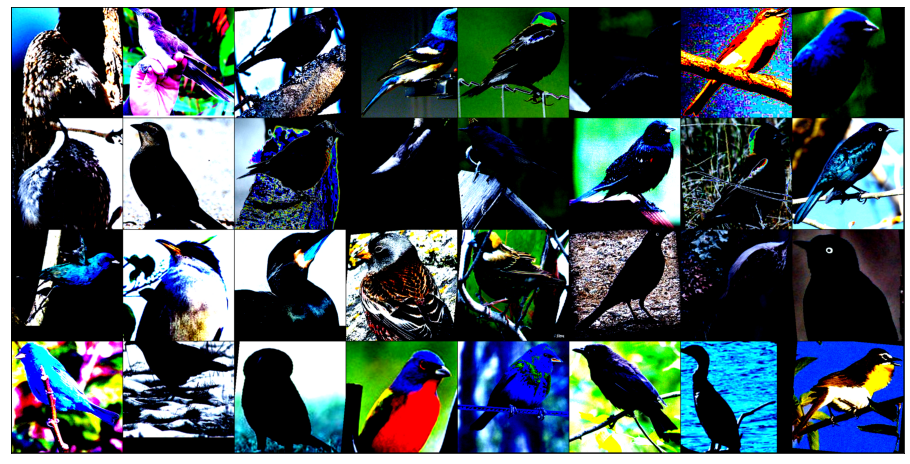

In [ ]:
def show_images(images, nmax=32):
    #cv2_imshow(images[0][0].permute(1,2,0))
    fig, ax = plt.subplots(figsize=(16, 16))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid((images[0][:nmax]), nrow=8).permute(1, 2, 0))
    return images[0]

it = iter(train_loader)
batch_images = show_images(next(it), batch_size)

## Model CNN : 

In [ ]:
from models import EfficientNet_transfer, vit

In [ ]:
drop1, drop2 = 0.5, 0.3

In [ ]:
model = EfficientNet_transfer(drop1, drop2)

In [ ]:
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

67,252,580 total parameters.
3,465,620 training parameters.


In [ ]:
# Neural network and optimizer
# We define neural net in model.py so that it can be reused by the evaluate.py script
optimizer = optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

## Model ViT : 

In [ ]:
timm.list_models('*vit*')

['convit_base',
 'convit_small',
 'convit_tiny',
 'levit_128',
 'levit_128s',
 'levit_192',
 'levit_256',
 'levit_384',
 'vit_base_patch16_224',
 'vit_base_patch16_224_in21k',
 'vit_base_patch16_224_miil',
 'vit_base_patch16_224_miil_in21k',
 'vit_base_patch16_384',
 'vit_base_patch32_224',
 'vit_base_patch32_224_in21k',
 'vit_base_patch32_384',
 'vit_base_r26_s32_224',
 'vit_base_r50_s16_224',
 'vit_base_r50_s16_224_in21k',
 'vit_base_r50_s16_384',
 'vit_base_resnet26d_224',
 'vit_base_resnet50_224_in21k',
 'vit_base_resnet50_384',
 'vit_base_resnet50d_224',
 'vit_huge_patch14_224_in21k',
 'vit_large_patch16_224',
 'vit_large_patch16_224_in21k',
 'vit_large_patch16_384',
 'vit_large_patch32_224',
 'vit_large_patch32_224_in21k',
 'vit_large_patch32_384',
 'vit_large_r50_s32_224',
 'vit_large_r50_s32_224_in21k',
 'vit_large_r50_s32_384',
 'vit_small_patch16_224',
 'vit_small_patch16_224_in21k',
 'vit_small_patch16_384',
 'vit_small_patch32_224',
 'vit_small_patch32_224_in21k',
 'vit_sma

model tested :


- vit_base_resnet50_384
- vit_large_patch32_384


In [ ]:
model = vit('vit_base_resnet50_384', drop1, drop2)

In [ ]:
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')


98,517,768 total parameters.
335,816 training parameters.


In [ ]:
# Neural network and optimizer
# We define neural net in model.py so that it can be reused by the evaluate.py script
optimizer = optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

## Training : 

In [ ]:
from train import EarlyStopping, fit, validate

: 

In [ ]:
early_stopping = EarlyStopping(patience=4, min_delta=0)

In [ ]:
# Training Loop : 
train_loss, train_accuracy = [], []
val_loss, val_accuracy = [], []
start = time.time()
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_accuracy = fit(
        model, train_loader, train_dataset, optimizer, criterion
    )
    val_epoch_loss, val_epoch_accuracy = validate(
        model, val_loader, val_dataset, criterion
    )
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
  
    early_stopping(val_epoch_loss)
    if early_stopping.early_stop:
        break
    print(f"Train Loss: {train_epoch_loss:.4f}, Train Acc: {train_epoch_accuracy:.2f}")
    print(f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_accuracy:.2f}')
end = time.time()
print(f"Training time: {(end-start)/60:.3f} minutes")

Epoch 1 of 30
Training


34it [00:27,  1.22it/s]

Validating



4it [00:03,  1.33it/s]

Train Loss: 2.2453, Train Acc: 33.92
Val Loss: 0.7261, Val Acc: 85.44
Epoch 2 of 30
Training



 36%|███▋      | 12/33 [00:10<00:19,  1.10it/s]


KeyboardInterrupt: ignored

# Test : 

In [ ]:
preds = np.array([])
model.eval()
with torch.no_grad():
    for i, (data, labels) in tqdm(enumerate(test_loader, 0)):
        data, labels = data.to(device), labels.to(device)
        output1 = model(data)
        sm = nn.Softmax(dim=1)(output1)
        pred = sm.max(1, keepdim=True)[1]    
        preds = np.hstack((preds, torch.squeeze(pred).cpu().numpy()))

517it [01:36,  5.38it/s]


In [ ]:
f = open("submission.csv", "w")
f.write("Id,Category\n")
for (n,_),p in zip(test_loader.dataset.samples,preds):
    f.write("{},{}\n".format(n.split('/')[-1].split('.')[0], int(p)))
f.close()